# PINNs on Graphs

This notebook accompanies the paper


---

In this notebook, we describe and illustrate the methodology proposed in the aforementioned paper.
Here, we deal with the solution of a drift-diffuion equation on a metric graph.
A metric graph is an undirected graph that consists of a set of vertices $\mathcal V$ and edges $\mathcal E$ where in contrast to combinatorial graphs a length $l_e$ is assigned to each edge $e \in \mathcal E$.
Each edge $e \in \mathcal E$ connects a pair of nodes $(v_{e_a},v_{e_b})$ with $v_{e_a}, v_{e_b} \in \mathcal V$

We consider the drift-diffusion equation posed on each edge

$$
\partial_t u = \partial_x ( \varepsilon \partial_x \rho_e - f(\rho_e) \partial_x V_e), \quad e \in \mathcal E
$$

where $\rho_e : [0,l_e] \times (0,T) \to \mathbb{R}_+$ describes, on each edge, the concentration of some quantity while $V_e: [0,l_e] \times(0,T)\to \mathbb{R}_+$ is a given potential and $\varepsilon > 0$ a given constant, typically small.

To make this a well-posed problem, we need a set of initial conditions as well as coupling conditions in the vertices.
- For vertices $v \in \mathcal V_{\mathcal K} \subset \mathcal V$, we apply homogeneous Neumann-Kirchhoff conditions, i.e., there holds
$$
\sum_{e \in \mathcal{E}_v} J_e \, n_{e} (v) = 0 \quad v \in \mathcal V_{\mathcal K},
$$
where we additionally ask the solution to be continuous over the edges, i.e.
$$
p_e(v) = p_{e^{'}}(v)
\quad \text{for all } v \in \mathcal{V}_{\mathcal K}, e, e^{'} \in \mathcal{E}_v
$$
with $\mathcal E_v$ the edge set incident to the vertex $v$.
- For vertices $v \in \mathcal V_{\mathcal D} := \mathcal V \setminus \mathcal{V}_{\mathcal K}$ the solution fulfills flux boundary conditions
$$
J_e \, n_e (v) = - \alpha_v \, (1-u_v) + \beta_v \, u_v \quad \text{for all } e \in \mathcal E_v.
$$

Import necessary packages.

In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
from quantumGraphSolverFVM import QuantumGraphSolverFVM
import graph

## Set up class GraphPINNs

Next, we define the class `GraphPINN`, which is employed in the subsequent code.
The idea is to have one vanilla `PINN` for each edge which are connected via boundary and vertex conditions which are enforced weakly.

---

First, we define the model for a `PINN` which consists of one scaling layer, a number of fully connected hidden layers and one final output layer.

In [4]:
from tensorflow.keras import backend as Kback
def my_act(x):
    e1 = Kback.exp(x)
    e2 = Kback.exp(-x)
    return Kback.log(e1+e2)

In [5]:


# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=2,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation='tanh')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In [6]:
# Define model architecture
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=1,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('sigmoid')

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [7]:
DTYPE = 'float64'
# Lower bounds
lb = tf.constant([0, 0], dtype=DTYPE)

# Upper bounds
ub = tf.constant([10, 1], dtype=DTYPE)

pinn = PINN_ResNet(lb=lb, ub=ub)
pinn(tf.constant([[1., 1.],[1., 0.], [0., 1.]]))

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[ 0.11154139],
       [-1.6733141 ],
       [ 0.32105917]], dtype=float32)>

In [8]:
tmp=pinn.ResNet[0]
tmp.weights[0]

<tf.Variable 'pinn__res_net/dense/kernel:0' shape=(2, 16) dtype=float32, numpy=
array([[-0.27687982,  0.16449821, -0.44482893,  0.28952432, -0.1362639 ,
        -0.11831725,  0.41135842,  0.08143419, -0.18595484,  0.41718036,
         0.56596875,  0.12589699,  0.03094161,  0.03828293,  0.10116649,
         0.0028798 ],
       [-0.07286531, -0.00726688,  0.11128771, -0.37469408, -0.15400398,
         0.05668771,  0.26147926, -0.5443089 , -0.5064845 , -0.25514996,
        -0.31420735, -0.51759565,  0.57663953, -0.00267607,  0.00634873,
        -0.32392204]], dtype=float32)>

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [9]:
import networkx as nx

class GraphPINN():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        if isinstance(inp, nx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = nx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = nx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Determine graph layout if necessary
        self.pos = nx.kamada_kawai_layout(self.G)
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
        
            
    def _setupNNs(self):
        
        self.NNs = Sequential()
        self.NNs.add(Dense(20, input_dim=2, activation='tanh'))
        self.NNs.add(Dense(20, activation='tanh'))
        self.NNs.add(Dense(20, activation='tanh'))
        self.NNs.add(Dense(self.ne, activation='tanh'))
        
    
    def plotGraph(self, **kwargs):

        nx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [10]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 5
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Vin: [[], [], [0, 1], [2], [3], [4]]
Vout: [[0], [1], [2], [3, 4], [], []]


{0: array([0.61338534, 0.935451  ]),
 1: array([0.500243, 1.      ]),
 2: array([0.18949096, 0.32161507]),
 3: array([-0.18377935, -0.32492122]),
 4: array([-0.61590406, -0.93321776]),
 5: array([-0.5034359 , -0.99892709])}

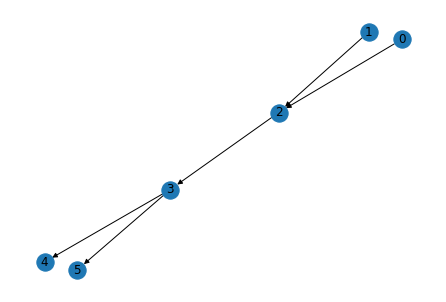

In [11]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

Draw collocation points uniformly or take them equidistantly distributed.

In [12]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

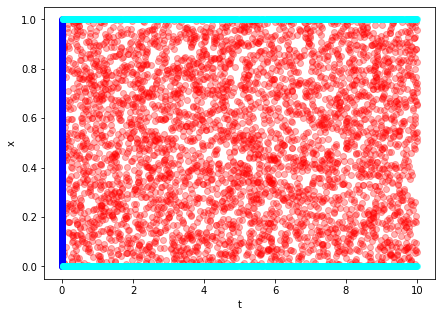

In [13]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

In [14]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN, Xr, X0, Xl, Xu):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self._updateData(Xr, X0, Xl, Xu)
        
        

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        self.graphPINN.NNs(tf.constant([[1., 1.]], dtype=DTYPE))
        self.trainable_variables.append(self.graphPINN.NNs.trainable_variables)
        
#         self.graphPINN.NNs(tf.constant([[1., 1.]], dtype=DTYPE))
#         self.trainable_variables = self.graphPINN.NNs.trainable_variables
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(self.nb,), dtype=DTYPE), trainable=True))

    def _fvals0(self, t, x):

        tx = tf.stack([t, x], axis=1)

        return self.graphPINN.NNs(tx)
    
    
    def _fvals1(self, t, x):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            tx = tf.stack([t, x], axis=1)
            # Compute current values u(t,x)
            u = self.graphPINN.NNs(tx)[:,0]

        ut = tape.gradient(u, t)
        ux = tape.gradient(u, x)
        u = tf.reshape(u, (u.shape[0], 1))
        ux = tf.reshape(ux, (ux.shape[0], 1))
        ut = tf.reshape(ut, (ut.shape[0], 1))
        del tape
        
        for i in range(1,self.ne):
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)
                tx = tf.stack([t, x], axis=1)
                # Compute current values u(t,x)
                u_col = self.graphPINN.NNs(tx)[:,i]
                
            ut_col = tape.gradient(u_col, t)
            ut = tf.concat([ut, tf.reshape(ut_col, (ut_col.shape[0], 1))], axis = 1)
            ux_col = tape.gradient(u_col, x)
            ux = tf.concat([ux, tf.reshape(ux_col, (ux_col.shape[0], 1))], axis = 1)
            u = tf.concat([u, tf.reshape(u_col, (u_col.shape[0], 1))], axis = 1)
            del tape
            
            
        
                
        return u, ut, ux
    
    
    def _fvals2(self, t, x):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(t)
            tape.watch(x)
            tx = tf.stack([t, x], axis=1)
            # Compute current values u(t,x)
            u = self.graphPINN.NNs(tx)[:,0]
            ux = tape.gradient(u, x)

        ut = tape.gradient(u, t)
        uxx = tape.gradient(ux, x)
        
        u = tf.reshape(u, (u.shape[0], 1))
        ux = tf.reshape(ux, (ux.shape[0], 1))
        ut = tf.reshape(ut, (ut.shape[0], 1))
        uxx = tf.reshape(uxx, (uxx.shape[0], 1))
        del tape
        
        for i in range(1,self.ne):
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)
                tx = tf.stack([t, x], axis=1)
                # Compute current values u(t,x)
                u_col = self.graphPINN.NNs(tx)[:,i]
                ux_col = tape.gradient(u_col, x)
                
            ut_col = tape.gradient(u_col, t)
            ut = tf.concat([ut, tf.reshape(ut_col, (ut_col.shape[0], 1))], axis = 1)
            uxx_col = tape.gradient(ux_col, x)
            uxx = tf.concat([uxx, tf.reshape(uxx_col, (uxx_col.shape[0], 1))], axis = 1)
            u = tf.concat([u, tf.reshape(u_col, (u_col.shape[0], 1))], axis = 1)
            ux = tf.concat([ux, tf.reshape(ux_col, (ux_col.shape[0], 1))], axis = 1)
            del tape
        
        
                
        return u, ut, ux, uxx
    
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        u, ut, ux, uxx = self._fvals2(self.Xr[:,0], self.Xr[:,1])
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[:,i], ut[:,i], ux[:,i], uxx[:,i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        u = self._fvals0(self.X0[:,0], self.X0[:,1])
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[:,i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[:,j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[:,j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[:,j], uux[:,j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[:,j], ulx[:,j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[:,j], uux[:,j]) \
                    - beta * (uu[:,j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[:,j], ulx[:,j]) \
                    + alpha * (1-ul[:,j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [15]:
#solver.graphPINN.NNs[0](tf.constant([[1., 1.]]))

In [16]:
gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

In [17]:
tf.random.set_seed(1)
X_test = tf.random.uniform((4000,), dtype=DTYPE)
T_test = tf.random.uniform((4000,), dtype=DTYPE)

u, ut, ux, uxx = solver._fvals2(T_test, X_test)
print(u.shape)
print(ut)
print(ux)
print(uxx)

(4000, 5)
tf.Tensor(
[[ 0.37984622 -0.45722828  0.30604949 -0.36572583 -0.41626393]
 [ 0.36575088 -0.41877118  0.33291531 -0.36076227 -0.38572514]
 [ 0.23697313 -0.29067111  0.37422114 -0.29241786 -0.28974553]
 ...
 [ 0.20679817 -0.31646397  0.23938144 -0.23928984 -0.26887985]
 [ 0.34219155 -0.41509117  0.3422862  -0.34932055 -0.39012949]
 [ 0.25566161 -0.36711209  0.21594469 -0.27202048 -0.30590051]], shape=(4000, 5), dtype=float64)
tf.Tensor(
[[ 0.49983263 -0.13597106 -0.68670041  0.07042306  0.10557514]
 [ 0.53801805 -0.15024389 -0.76292147  0.0921979   0.12516715]
 [ 0.43075386 -0.10510831 -0.71362599  0.11509191  0.13274265]
 ...
 [ 0.23929407 -0.01281878 -0.36407254  0.04608292  0.06425123]
 [ 0.49257634 -0.13208705 -0.73004229  0.08852189  0.122668  ]
 [ 0.27751368 -0.03329071 -0.37196347  0.03539253  0.05071282]], shape=(4000, 5), dtype=float64)
tf.Tensor(
[[-0.32104252  0.13929679  0.60246465 -0.09980127 -0.1302656 ]
 [-0.10541233  0.03767328 -0.15136143  0.05398985  0.0605621

In [18]:
# print(len(solver.trainable_variables))
# loss, g = solver.get_grad()
# print(len(g))
# print(zip(g, solver.trainable_variables))
# loss, g = solver.get_grad()
# result = zip(g, solver.trainable_variables)
# loss, g = solver.get_grad()
# print(len(g))
# print(len(solver.trainable_variables))
# print(g)
# print(solver.trainable_variables[0][0])

# for v in solver.trainable_variables:
#     print(v.shape)
#     print(i)
#     i = i+1

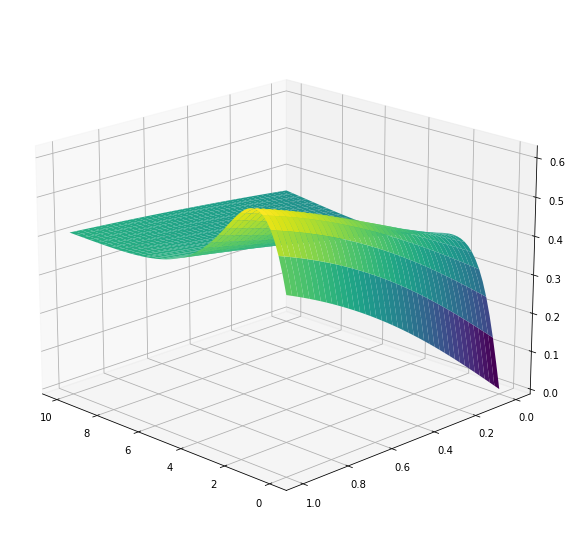

In [19]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs(TX)[:, Eidx]
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)
#print(U)

In [20]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)


Start with TF optimizer

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  2
incoming edge: 0
incoming edge: 1
outgoing edge: 2
Kirchhoff-Neumann in node  3
incoming edge: 2
outgoing edge: 3
outgoing edge: 4

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
Tensor("add_9:0", shape=(), dtype=float64)
Tensor("add_14:0", shape=(), dtype=float64)
Tensor("add_20:0", shape=(), dtype=float64)
Tensor("add_31:0", shape=(), dtype=float64)
Tensor("add_45:0", shape=(), dtype=float64)
00000  6.81872775e+00   4.17
00020  4.86428766e-01   6.58
00040  2.49335766e-01   9.01
00060  1.93732552e-01   11.31
00080  1.52838180e-01   14.20
00100  1.26922936e-01   16.74
00120  1.09761476e-01   19.22
00140  9.86343209e-02   21.40
00160  9.09774940e-02   23.70
00180  9.43118163e-02   26.21
00200  8.55038143e-02   28.77
00220  7.43264589e-02   31.50
0

In [21]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 2000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 50000,
                                     'maxfun': 500000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  5.50041404e-02   1.66
02040  5.40128727e-02   3.10
02060  5.28879776e-02   4.86
02080  5.20157295e-02   6.74
02100  5.13115052e-02   8.64
02120  5.04328391e-02   10.68
02140  4.93939081e-02   12.73
02160  4.82439420e-02   14.66
02180  4.65175296e-02   16.51
02200  4.43930257e-02   18.36
02220  4.23716232e-02   20.21
02240  4.09269415e-02   22.07
02260  3.98327036e-02   23.96
02280  3.87558647e-02   25.99
02300  3.80227820e-02   27.92
02320  3.69886485e-02   29.84
02340  3.59929691e-02   31.70
02360  3.50853406e-02   33.56
02380  3.40083290e-02   35.52
02400  3.26810488e-02   37.40
02420  3.14136239e-02   39.48
02440  3.04385401e-02   41.68
02460  2.93936405e-02   43.78
02480  2.85362760e-02   45.95
02500  2.75349201e-02   47.94
02520  2.69359015e-02   49.82
02540  2.64297515e-02   51.68
02560  2.58775530e-02   53.56
02580  2.54755193e-02   55.56
02600  2.51682539e-02   57.62
02620  2.46873147

07300  4.61512991e-03   537.42
07320  4.60512658e-03   539.62
07340  4.59444184e-03   541.70
07360  4.58560633e-03   543.67
07380  4.57616419e-03   545.82
07400  4.56397792e-03   547.68
07420  4.55181742e-03   549.80
07440  4.54067002e-03   551.84
07460  4.53069048e-03   553.92
07480  4.51691707e-03   556.01
07500  4.50551972e-03   558.01
07520  4.49300238e-03   560.16
07540  4.48090968e-03   562.26
07560  4.47298829e-03   564.30
07580  4.46484421e-03   566.26
07600  4.45549195e-03   568.10
07620  4.44462608e-03   570.09
07640  4.43426171e-03   572.19
07660  4.42300278e-03   574.20
07680  4.41148396e-03   576.33
07700  4.40047545e-03   578.55
07720  4.38980593e-03   580.70
07740  4.37216617e-03   582.80
07760  4.35724273e-03   584.95
07780  4.33814222e-03   586.89
07800  4.32763970e-03   589.01
07820  4.31594689e-03   591.11
07840  4.30385552e-03   593.14
07860  4.29096896e-03   595.21
07880  4.27592466e-03   597.34
07900  4.26665966e-03   599.42
07920  4.25811940e-03   601.77
07940  4

12560  3.50436307e-03   1085.60
12580  3.50291827e-03   1087.75
12600  3.50137496e-03   1089.88
12620  3.50021779e-03   1092.08
12640  3.49921622e-03   1094.02
12660  3.49800109e-03   1096.15
12680  3.49711388e-03   1098.15
12700  3.49574819e-03   1100.34
12720  3.49403045e-03   1102.44
12740  3.49269847e-03   1104.37
12760  3.49159942e-03   1106.22
12780  3.49022081e-03   1108.25
12800  3.48920022e-03   1110.37
12820  3.48763904e-03   1112.32
12840  3.48612640e-03   1114.31
12860  3.48443066e-03   1116.42
12880  3.48282143e-03   1118.34
12900  3.48090186e-03   1120.28
12920  3.47932989e-03   1122.40
12940  3.47795845e-03   1124.36
12960  3.47674398e-03   1126.48
12980  3.47544402e-03   1128.41
13000  3.47460279e-03   1130.41
13020  3.47362589e-03   1132.53
13040  3.47260760e-03   1134.49
13060  3.47161117e-03   1136.62
13080  3.47054425e-03   1138.55
13100  3.46974601e-03   1140.49
13120  3.46875355e-03   1142.62
13140  3.46777938e-03   1144.69
13160  3.46670876e-03   1146.73
13180  3

17700  3.29923869e-03   1610.09
17720  3.29865925e-03   1612.29
17740  3.29800376e-03   1614.33
17760  3.29735871e-03   1616.27
17780  3.29684838e-03   1618.11
17800  3.29628994e-03   1619.96
17820  3.29567149e-03   1621.88
17840  3.29501585e-03   1623.84
17860  3.29447588e-03   1625.88
17880  3.29391098e-03   1628.09
17900  3.29344067e-03   1630.07
17920  3.29300780e-03   1632.12
17940  3.29254839e-03   1634.05
17960  3.29185992e-03   1635.92
17980  3.29130624e-03   1637.94
18000  3.29078201e-03   1639.79
18020  3.29026196e-03   1641.69
18040  3.28978330e-03   1643.71
18060  3.28924703e-03   1645.82
18080  3.28878322e-03   1647.86
18100  3.28838951e-03   1649.90
18120  3.28793967e-03   1651.73
18140  3.28744643e-03   1653.78
18160  3.28669976e-03   1655.71
18180  3.28620642e-03   1657.88
18200  3.28564651e-03   1659.90
18220  3.28497875e-03   1662.00
18240  3.28461774e-03   1664.12
18260  3.28420148e-03   1666.13
18280  3.28362203e-03   1668.22
18300  3.28327631e-03   1670.27
18320  3

22840  2.85921368e-03   2136.05
22860  2.85056598e-03   2138.21
22880  2.84211908e-03   2140.36
22900  2.83470526e-03   2142.70
22920  2.82712109e-03   2144.81
22940  2.81985202e-03   2146.75
22960  2.81276061e-03   2148.83
22980  2.80423088e-03   2150.77
23000  2.79602814e-03   2153.00
23020  2.78729912e-03   2154.94
23040  2.77684604e-03   2156.98
23060  2.76593552e-03   2159.05
23080  2.75416019e-03   2160.99
23100  2.74456461e-03   2163.03
23120  2.72805557e-03   2165.23
23140  2.71267446e-03   2167.19
23160  2.70332334e-03   2169.07
23180  2.69400399e-03   2171.11
23200  2.68382256e-03   2173.32
23220  2.67372837e-03   2175.40
23240  2.66420128e-03   2177.46
23260  2.65637491e-03   2179.59
23280  2.64677251e-03   2181.64
23300  2.63496117e-03   2183.68
23320  2.61978322e-03   2185.56
23340  2.60857505e-03   2187.60
23360  2.59463660e-03   2189.64
23380  2.58017818e-03   2191.88
23400  2.56777731e-03   2193.93
23420  2.55893241e-03   2195.97
23440  2.55002811e-03   2198.01
23460  2

27980  9.85118887e-04   2668.47
28000  9.84157423e-04   2670.59
28020  9.83352944e-04   2672.55
28040  9.82446379e-04   2674.43
28060  9.81534360e-04   2676.44
28080  9.80520532e-04   2678.42
28100  9.79793857e-04   2680.38
28120  9.79137028e-04   2682.52
28140  9.78614057e-04   2684.50
28160  9.77963367e-04   2686.73
28180  9.76905370e-04   2688.78
28200  9.76138373e-04   2690.83
28220  9.75425777e-04   2693.01
28240  9.74427895e-04   2695.09
28260  9.73546466e-04   2697.06
28280  9.72709642e-04   2699.17
28300  9.71825727e-04   2701.46
28320  9.70802885e-04   2703.39
28340  9.69961715e-04   2705.41
28360  9.69228409e-04   2707.58
28380  9.68639335e-04   2709.68
28400  9.68047227e-04   2711.64
28420  9.67210042e-04   2713.65
28440  9.66569389e-04   2715.79
28460  9.65975681e-04   2717.93
28480  9.65250445e-04   2719.96
28500  9.64454162e-04   2722.02
28520  9.63333830e-04   2724.09
28540  9.62569451e-04   2726.23
28560  9.61983636e-04   2728.31
28580  9.60945594e-04   2730.33
28600  9

33120  7.59715544e-04   3202.13
33140  7.58985198e-04   3204.18
33160  7.58347946e-04   3206.14
33180  7.57565282e-04   3208.02
33200  7.56869558e-04   3209.94
33220  7.56260202e-04   3212.11
33240  7.55410433e-04   3214.17
33260  7.54587412e-04   3216.16
33280  7.53660718e-04   3218.16
33300  7.52835203e-04   3220.31
33320  7.52214581e-04   3222.18
33340  7.51522451e-04   3224.17
33360  7.50766431e-04   3226.18
33380  7.49867535e-04   3228.23
33400  7.48838921e-04   3230.30
33420  7.48072170e-04   3232.28
33440  7.47384984e-04   3234.35
33460  7.46534899e-04   3236.32
33480  7.45658554e-04   3238.32
33500  7.44599550e-04   3240.38
33520  7.43622844e-04   3242.39
33540  7.42955892e-04   3244.55
33560  7.42026235e-04   3246.67
33580  7.41319789e-04   3248.74
33600  7.40477196e-04   3250.62
33620  7.39526991e-04   3252.77
33640  7.38417858e-04   3254.79
33660  7.37714941e-04   3256.87
33680  7.37045375e-04   3258.91
33700  7.36396580e-04   3261.06
33720  7.35833473e-04   3263.21
33740  7

38260  6.58521630e-04   3737.17
38280  6.58283955e-04   3739.37
38300  6.58020651e-04   3741.36
38320  6.57751370e-04   3743.69
38340  6.57507524e-04   3745.78
38360  6.57314305e-04   3747.77
38380  6.57023504e-04   3749.95
38400  6.56740652e-04   3751.89
38420  6.56485260e-04   3753.90
38440  6.56166538e-04   3756.08
38460  6.55908778e-04   3758.27
38480  6.55734115e-04   3760.22
38500  6.55532885e-04   3762.21
38520  6.55309119e-04   3764.31
38540  6.55127686e-04   3766.41
38560  6.54822490e-04   3768.50
38580  6.54586596e-04   3770.55
38600  6.54356355e-04   3772.59
38620  6.54166016e-04   3774.69
38640  6.53977387e-04   3776.70
38660  6.53800795e-04   3778.92
38680  6.53492409e-04   3780.92
38700  6.53251475e-04   3782.96
38720  6.52952083e-04   3785.06
38740  6.52624853e-04   3787.16
38760  6.52395909e-04   3789.33
38780  6.52142578e-04   3791.42
38800  6.51878977e-04   3793.51
38820  6.51575763e-04   3795.59
38840  6.51375946e-04   3797.77
38860  6.51206836e-04   3799.76
38880  6

43400  5.96068446e-04   4283.67
43420  5.95760576e-04   4285.95
43440  5.95514632e-04   4288.01
43460  5.95213343e-04   4290.11
43480  5.94896625e-04   4292.54
43500  5.94414902e-04   4294.62
43520  5.94018605e-04   4296.72
43540  5.93510528e-04   4299.00
43560  5.92952588e-04   4301.43
43580  5.92519483e-04   4303.73
43600  5.92174701e-04   4305.82
43620  5.91871465e-04   4307.95
43640  5.91554912e-04   4310.21
43660  5.91041524e-04   4312.39
43680  5.90627027e-04   4314.55
43700  5.90231559e-04   4316.87
43720  5.89752057e-04   4319.02
43740  5.89204663e-04   4321.03
43760  5.88681812e-04   4323.24
43780  5.88012573e-04   4325.35
43800  5.87547910e-04   4327.41
43820  5.87004802e-04   4329.62
43840  5.86581581e-04   4332.00
43860  5.86273318e-04   4334.21
43880  5.85617589e-04   4336.34
43900  5.85073793e-04   4338.34
43920  5.84482374e-04   4340.55
43940  5.83953156e-04   4342.74
43960  5.83355869e-04   4344.87
43980  5.82624992e-04   4346.94
44000  5.82054173e-04   4349.26
44020  5

48540  4.81323978e-04   4854.08
48560  4.81131415e-04   4856.31
48580  4.80879918e-04   4858.76
48600  4.80657605e-04   4861.12
48620  4.80414389e-04   4863.38
48640  4.80202546e-04   4865.44
48660  4.79973993e-04   4867.51
48680  4.79832544e-04   4869.84
48700  4.79662882e-04   4871.96
48720  4.79523364e-04   4874.12
48740  4.79396073e-04   4876.36
48760  4.79215293e-04   4878.57
48780  4.79053399e-04   4880.69
48800  4.78813952e-04   4882.71
48820  4.78582536e-04   4884.92
48840  4.78386499e-04   4887.18
48860  4.78155653e-04   4889.31
48880  4.77973078e-04   4891.74
48900  4.77759054e-04   4893.95
48920  4.77526177e-04   4896.30
48940  4.77329804e-04   4898.47
48960  4.77090283e-04   4900.60
48980  4.76879857e-04   4902.81
49000  4.76674698e-04   4905.07
49020  4.76393424e-04   4907.34
49040  4.76223054e-04   4909.57
49060  4.76030051e-04   4911.90
49080  4.75839203e-04   4914.34
49100  4.75626188e-04   4916.73
49120  4.75402256e-04   4919.24
49140  4.75200096e-04   4921.66
49160  4

In [22]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs(tf.concat([t0,xspace],axis=1))[:, i]
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

<Figure size 720x720 with 0 Axes>

Surface plot of function values on a single edge.

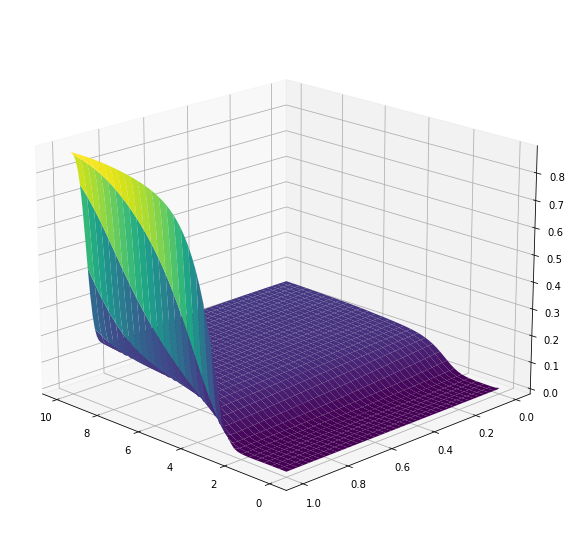

In [28]:
Eidx = 4

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs(TX)[:, Eidx] #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [29]:
xth_frame = 5
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of FVM
nx = N_0 + 1

graph_FVM = graph.Example2()
graph_FVM.buildGraph()

fvm_solver = QuantumGraphSolverFVM(graph_FVM)
u_fvm = fvm_solver.solve(nx=nx, nt=nt)

In [34]:
u_new = np.delete(u_fvm, 5000, axis=0)
u_new = np.delete(u_new, 4000, axis=0)
u_new = np.delete(u_new, 3000, axis=0)
u_new = np.delete(u_new, 2000, axis=0)
u_new = np.delete(u_new, 1000, axis=0)
u_new = np.delete(u_new, 0, axis=0)

u_new.shape


(4995, 5000)

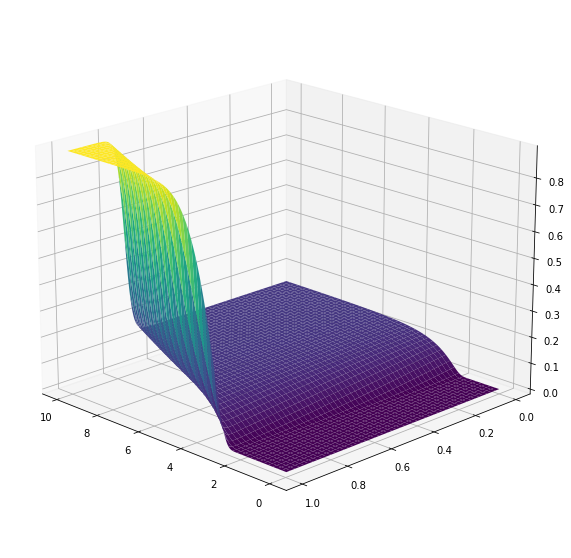

In [30]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

t_fvm = [i * 1./500. for i in range(np.shape(u_fvm)[1])]
x_fvm = [i / nx for i in range(1000)]

T, X = tf.meshgrid(t_fvm[:], x_fvm[:999])
ax.plot_surface(T, X, u_fvm[3996:4995, :], cmap='viridis')
ax.view_init(19, 135)

In [126]:
u_fvm.shape

(5001, 5000)

In [148]:
T, X = tf.meshgrid(t_fvm, x_fvm[:999])
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
# U1 = solver.graphPINN.NNs[0](TX)
# U1 = tf.reshape(U1, T.shape)
# U2 = solver.graphPINN.NNs[1](TX)
# U2 = tf.reshape(U2, T.shape)
# U3 = solver.graphPINN.NNs[2](TX)
# U3 = tf.reshape(U3, T.shape)
# U4 = solver.graphPINN.NNs[3](TX)
# U4 = tf.reshape(U4, T.shape)
# U5 = solver.graphPINN.NNs[4](TX)
# U5 = tf.reshape(U5, T.shape)
U = solver.graphPINN.NNs(TX)[:,3]
#U_final = tf.reshape(U, (4995, 5000))
U_final = tf.reshape(U, T.shape)

In [154]:
tf.linalg.norm(U_final - u_fvm[3998:4997, :])

<tf.Tensor: shape=(), dtype=float64, numpy=423.0578895208441>

In [31]:
T, X = tf.meshgrid(t_fvm, x_fvm[:999])
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U1 = solver.graphPINN.NNs(TX)[:,0]
U1 = tf.reshape(U1, T.shape)
U2 = solver.graphPINN.NNs(TX)[:,1]
U2 = tf.reshape(U2, T.shape)
U3 = solver.graphPINN.NNs(TX)[:,2]
U3 = tf.reshape(U3, T.shape)
U4 = solver.graphPINN.NNs(TX)[:,3]
U4 = tf.reshape(U4, T.shape)
U5 = solver.graphPINN.NNs(TX)[:,4]
U5 = tf.reshape(U5, T.shape)

In [36]:
U_FNN = tf.concat([U1, U2, U3, U4, U5], axis = 0)
print(tf.linalg.norm(U_FNN - u_fvm[:4995, :]))
print(np.max(tf.abs(U_FNN - u_fvm[:4995, :])))
# print(tf.linalg.norm(U_FNN - u_new))
# print(np.max(tf.abs(U_FNN - u_new)))

tf.Tensor(430.4514416907528, shape=(), dtype=float64)
0.7684574683811376


In [172]:
A = tf.abs(U_FNN - u_fvm[:4995, :])

ind = np.argmax(A.numpy(), axis=1)
for i in ind:
    if i != 0:
        print(i)

10
11
11
12
13
13
14
15
15
16
16
17
17
17
18
18
19
19
19
20
20
21
21
21
22
22
22
23
23
23
24
24
25
25
25
26
26
27
27
27
28
28
29
29
30
30
30
31
31
32
32
33
33
34
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
2692
2691
2690
2689
2687
2686
2685
2684
2683
2682
2681
2680
2679
2677
2676
2675
2674
2673
2672
2671
2669
2668
2667
2666
2665
2664
2663
2661
2660
2659
2658
2657
2656
2654
2653
2652
2651
2650
2649
2647
2646
2645
2644
2643
2641
2640
2639
2638
2637
2635
2634
2633
2632
2631
2629
2628
2627
2626
2624
2623
2622
2621
2620
2618
2617
2616
2615
2613
2612
2611
2610
2608
2607
2606
2605
2603
2602
2601
2600
2598
2597
2596
2595
2593
2592
2591
2589
2588
2587
2586
2584
2583
2582
2581
2579
2578
2577
2575
2574
2573
2572
2570
2569
2568
2566
2565
2564
2562
2561
2560
2559
2557
2556
2555
2553
2552
2551
2549
2548
2547
2545
2544
2543
2541
2540
2539
2537
2536
2535
2533
2532
2531
2529
2528
2527
2525
2524
2523
2521
2520
2519
2517
2516
2515
2513
2512
2511
2509
2508
2507
2505
2504
2502
2

1190
1190
1190
1191
1191
1192
1192
1192
1193
1193
1193
1194
1194
1194
1195
1195
1195
1195
1196
1196
1196
1196
1196
1196
1197
1197
1197
1197
1197
1197
1196
1196
1196
1196
1196
1195
1195
1195
1194
1194
1193
1193
1192
1191
1190
1190
1189
1188
1187
1186
1185
1183
1182
1181
1179
1178
1176
1175
1173
1171
1169
1167
1165
1162
3606
3598
3589
1168
1168
1169
1170
1170
1171
1172
1172
1173
1174
1174
1175
1176
1176
1177
1178
1178
1179
1180
1180
1181
1182
1183
1183
1184
1185
1185
1186
1187
1188
1188
1189
1190
1190
1191
1192
1192
1193
1194
1195
1195
1196
1197
1197
1198
1199
1199
1200
1201
1201
1202
1203
1204
1204
1205
1206
1206
1207
1208
1208
1209
1210
1210
1211
1212
1212
1213
1214
1214
1215
1216
1216
1217
1217
1218
1219
1219
1220
1221
1221
1222
1223
1223
1224
1225
1225
1226
1226
1227
1228
1228
1229
1230
1230
1231
1231
1232
1233
1233
1234
1235
1235
1236
1236
1237
1238
1238
1239
1240
1240
1241
1241
1242
1243
1243
1244
1244
1245
1246
1246
1247
1247
1248
1249
1249
1250
1250
1251
1252
1252
1253
1253
1254


In [168]:
A[4844, 4999]

<tf.Tensor: shape=(), dtype=float64, numpy=0.7703521850952177>

In [130]:
print(tf.linalg.norm(U_final - u_fvm[:4995, :]))
print(np.max(tf.abs(U_final - u_fvm[:4995, :])))

tf.Tensor(2097.8626380116825, shape=(), dtype=float64)
0.9008832062023462


In [124]:
print(tf.linalg.norm(U_final - u_new))
print(np.max(tf.abs(U_final - u_new)))

tf.Tensor(2098.147929280402, shape=(), dtype=float64)
0.9008923685588117
